In [36]:
import numpy as np
from numpy import random
import random
import matplotlib.pyplot as plt
from scipy.signal import cwt,ricker
from scipy import stats
from sklearn.preprocessing import StandardScaler,normalize
from sklearn.preprocessing import MinMaxScaler
import os
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.optimizers
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.models import load_model
from tensorflow.keras.layers import Flatten,concatenate,Layer,Dense,LSTM,Activation,MaxPooling2D,Dropout,Conv2D,BatchNormalization,Reshape,UpSampling2D,ZeroPadding2D
import nibabel as nib
import pydicom as dicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import tensorflow_io as tfio
import radiomics
from radiomics.featureextractor import RadiomicsFeatureExtractor
import SimpleITK as sitk


# Training

In [39]:
dict = './Lung_Train/'

# Function takes a list of folders, extract features from it, change the extractor inside function and the return dictionary
# to run exactly which feature, the key of the return dictionary can be found in mask.ipy and also listed in pyradiomics library
def LoadDataFromImages(foldernames):
    input_array = []
    output_array = []
    
    extractor = RadiomicsFeatureExtractor()
    # Disable all classes except firstorder
    extractor.disableAllFeatures()
    extractor.enableFeaturesByName(firstorder=['Mean'])  # change here to extract

    for i in foldernames:
        files  = os.listdir(dict + i)
        for j in files:
            im = sitk.ReadImage(dict + i +'/' + j)
            
            # reshape and fill the input array
            input_array.append(sitk.GetArrayFromImage(im)[0].reshape(512,512,1))
            
            ma_arr = np.ones(im.GetSize()[::-1])  # reverse the order as image is xyz, array is zyx
            ma = sitk.GetImageFromArray(ma_arr)
            ma.CopyInformation(im)  # Copy geometric info
            
            # extract features and fill the output array
            features = extractor.execute(im, ma)
            
            output_array.append(features['original_firstorder_Mean'])  # change here to extract
            
    return input_array, output_array

In [40]:
# load the data from folders

input_array = []
output_array = []

input_array, output_array = LoadDataFromImages(['d1'
                                                ,'d2', 'd3', 'd4','d5','d6','d7','d8','d9','d10','d11','d12',
                             'd2_1','d2_2', 'd2_3', 'd2_4','d2_5','d2_6','d2_7','d2_8','d2_9','d2_10','d2_11','d2_12'
                             ,'d3_1','d3_2', 'd3_3', 'd3_4','d3_5','d3_6','d3_7','d3_8'
                             ,'d3_9','d3_10','d3_11','d3_12'
                              ])

In [41]:
# convert to np array
input_array = np.array(input_array)
output_array = np.array(output_array)

In [24]:
# situation to prevent lost of data if out of memory
np.save("input_array.npy",input_array)
np.save("output_array.npy",output_array)

In [25]:
input_array = np.load("input_array.npy")
output_array = np.load("output_array.npy")

In [44]:
def MakeModel(modelname):
    input_layer = keras.Input(shape=(512,512,1))
    x = Flatten()(input_layer)
    x = BatchNormalization(axis=1)(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    out = Dense(1, activation = 'linear', name= modelname)(x)

    model = keras.Model(input_layer, out, name= modelname)
    
    return model

In [45]:
model = MakeModel('modelname')

In [46]:
model.compile(optimizer=tf.keras.optimizers.Adam(
 # learning_rate= 0.00000001
), loss="mse")

In [48]:
model.fit(input_array, output_array, 
              epochs=500, batch_size=64,
                shuffle=True
            )

Save, Load

In [ ]:
model.save("./radiomics_Energy.h5")

In [32]:
model = load_model("./radiomics_Mean.h5")

# Testing

In [29]:
input_array_t = []
output_array_t = []

input_array_t, output_array_t = LoadDataFromImages(['t1','t2','t3','t4'])

18/18 [==============================] - 1s 26ms/step


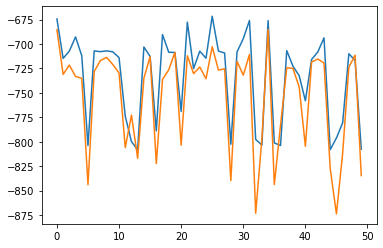

In [35]:
plt.plot(range(50),output_array_t[150:200] ,range(50),model.predict(input_array_t)[150:200] )